# Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  


## History
* Feb2022: Adding initial models with small dataset   
* March2022: Improved datasets representation
* May2022: Tidies VGG2D and VGG3D   
* June2022: Tidies basicVGG model

## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
from pathlib import Path
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop#, basicVGGNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes, split_train_validate_sets

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

REPOSITORY_PATH='repositories/echocardiography'
FULL_REPO_PATH = HOME_PATH+'/'+REPOSITORY_PATH
FULL_REPO_MODEL_PATH = HOME_PATH +'/' + REPOSITORY_PATH + '/models'
CONFIG_FILES_PATH= REPOSITORY_PATH + '/scripts/config_files/users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)
PATH_for_temporal_files = os.path.join(HOME_PATH, 'datasets/vital-us/echocardiography/temporal-files')

## Setting TRAINING_CURVES_PATH
#CURRENT_PATH=os.path.abspath(os.getcwd())
RESULTS_PATH='scripts/learning-pipeline/results'
TRAINING_CURVES_PATH = os.path.join(FULL_REPO_PATH, RESULTS_PATH)

## Setting FULL_PATH_FOR_YML_FILE
yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)

## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )
print(f'TRAINING_CURVES_PATH: {TRAINING_CURVES_PATH}' )


PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files/users_paths_files/config_users_paths_files_username_mx19.yml
TRAINING_CURVES_PATH: /home/mx19/repositories/echocardiography/scripts/learning-pipeline/results


## 2. Generate list text files for train and validate datasets

Edit config_users_paths_files_username_$USER.yml at '../config_files/users_paths_files/config_users_paths_files_username_template.yml' with the right paths and percentage of `ntraining`:  
```
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-GOOD'
TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default
randomise_file_list: False
```

In [2]:
##############################
##### Setting up device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") #or "cuda:NN" can also be used e.g., "cuda:0"
print(f'Device: {DEVICE}')

##############################
## Setting ECHODATASET_PATH; 
#ECHODATASET_PATH = config['echodataset_path'] # Default
ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-05-subjects'
#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-10-subjects'
#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-20-subjects'
#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-31-subjects'
#ECHODATASET_PATH = '/media/mx19/vitaluskcl/datasets/echocardiography/videos-echo-annotated-in-verification40-49'

TRAINING_SPLITTING = 0.8 #config['ntraining'] #Default

split_train_validate_sets(  
                        ECHODATASET_PATH, #config['echodataset_path']
                        config['data_list_output_path'], 
                        TRAINING_SPLITTING,
                        config['randomise_file_list']
                        )

NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
# PRETRANSFORM_IM_SIZE = [64, 64] #[650, 690] original pixel size for VenueGO
PRETRANSFORM_IM_SIZE = [128, 128] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [256, 256] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = [512, 512] #[650, 690] original pixel size for VenueGO
# PRETRANSFORM_IM_SIZE = config['pretransform_im_size'] ##DEFAULT

### >> CHANGE DENSE LAYER FEATURES IN VGG3D
### >> `self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128`

##############################
##### Setting up HYPERPARAMETERS
BATCH_SIZE_OF_CLIPS = 20

##### Setting up Model Parameters
LEARNING_RATE = 0.000005  # Trial and Error with diffent values 0.0000005 or 0.00005
#Learning rate: 0.000005; 0.00005; 0.0005; 0.005 and 0.000001; 0.00001; 0.0001; 0.001
    
MAX_EPOCHS = 100 #Alternatvely, make use of: config['max_epochs']

    
##############################
##### Setting up animation
interval_between_frames_in_milliseconds=33.3 ## 1/30=0.033333
frame_per_seconds_for_animated_frames=30


#SUBJECT_ID = '073'
#print(SUBJECT_ID)

### CUDA out of memory 
#NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP = 10
#PRETRANSFORM_IM_SIZE = [128, 128] 
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.05 GiB free; 8.53 GiB reserved in total by PyTorch)
## REBOOT MACHINE
#RuntimeError: CUDA out of memory. Tried to allocate 7.81 GiB (GPU 0; 15.74 GiB total capacity; 8.51 GiB already allocated; 5.13 GiB free; 8.53 GiB reserved in total by PyTorch)



##############################
## Setting labels
label_id = ('BKGR', '4CV')




Device: cuda
======= video_filenames: ['/01NVb-003-040/T1/01NVb-003-040-1 echo.mp4', '/01NVb-003-040/T2/01NVb-003-040-2 echo.mp4', '/01NVb-003-041/T1/01NVb-003-041-1 echo.mp4', '/01NVb-003-041/T2/01NVb-003-041-2 echo.mp4', '/01NVb-003-041/T3/01NVb-003-041-3 echo.mp4', '/01NVb-003-042/T1/01NVb-003-042-1 echo.mp4', '/01NVb-003-042/T2/01NVb-003-042-2 echo.mp4', '/01NVb-003-042/T3/01NVb-003-042-3 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-1 echo.mp4', '/01NVb-003-043/T1/01NVb-003-043-2 echo.mp4', '/01NVb-003-043/T3/01NVb-003-043-3 echo.mp4', '/01NVb-003-044/T1/01NVb-003-044-2 echo.mp4', '/01NVb-003-044/T3/01NVb-003-044-3 echo.mp4', '/01NVb-003-045/T1/01NVb-003-045-1 echo.mp4', '/01NVb-003-045/T2/01NVB-003-045-2 echo.mp4', '/01NVb-003-045/T3/01NVb-003-045-3 echo.mp4']
======= label_filenames: ['/01NVb-003-040/T1/01nvb-003-040-1-4cv.json', '/01NVb-003-040/T2/01nvb-003-040-2-4cv.json', '/01NVb-003-041/T1/01nvb-003-041-1-4cv.json', '/01NVb-003-041/T2/01nvb-003-041-2-4cv.json', '/01NVb-003-041

## 2. Setting variables and loading datasets using pytorch dataloader

In [3]:
# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=PRETRANSFORM_IM_SIZE),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )

validation_dataset = EchoClassesDataset(
    echodataset_path=ECHODATASET_PATH,
    temporal_data_path=config['temporal_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    pretransform_im_size=PRETRANSFORM_IM_SIZE,
    pretransform=pretransform,
    number_of_frames_per_segment_in_a_clip=NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP, #config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=DEVICE,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    transform=None,#transform=train_transform,
    use_tmp_storage=config['use_tmp_storage']
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.7

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(f'Ntrain size: {Ntrain}, Ntest size: {Ntest}, "Ntrain+Ntest" size={Ntrain+Ntest}')
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])


Ntrain size: 36, Ntest size: 16, "Ntrain+Ntest" size=52


## 3. Modules 

In [4]:
def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


def creating_pair_of_clips(dataset):
    number_of_clips = len(dataset)
    clips=[]
    for clip_index in range( int(number_of_clips)  ):
        data_idx = dataset[clip_index]
        data_clip_idx = data_idx[0]
        label_clip_idx = data_idx[1]
        clip_frame_clip_idx = data_idx[2]
        n_available_frames_clip_idx = data_idx[3]
        print(f' CLIP:{clip_index:02d} of {label_id[label_clip_idx]} label for {data_clip_idx.size()} TOTAL_FRAMES: {n_available_frames_clip_idx} from clip_frame_clip_idx {clip_frame_clip_idx}')    
        clips.append([data_clip_idx, label_clip_idx, clip_index, clip_frame_clip_idx, n_available_frames_clip_idx ]) 

    return(clips)


def pair_clips_labels(clips):
    pair_clips_labels_=[]    
    number_of_clips=len(clips)
    for clip_index_i_A in range( int(number_of_clips/2)  ):
        clip_index_i_B=int(number_of_clips/2) + clip_index_i_A 
        print(f' pair_clips_labels[{clip_index_i_A}]-- BKRG:{clip_index_i_A}, 4CV:{clip_index_i_B}')
        data_clip_i_A=clips[clip_index_i_A][0]
        label_i_A=clips[clip_index_i_A][1]
        clip_i_A=clips[clip_index_i_A][2]
        number_of_frames_A=clips[clip_index_i_A][4]
        data_clip_i_B=clips[clip_index_i_B][0]
        label_i_B=clips[clip_index_i_B][1]
        clip_i_B=clips[clip_index_i_B][2]
        number_of_frames_B=clips[clip_index_i_B][4]
        pair_clips_labels_.append([data_clip_i_A, label_i_A, clip_i_A, number_of_frames_A, data_clip_i_B, label_i_B, clip_i_B, number_of_frames_B])
    
    return(pair_clips_labels_)


def animate_clips(pair_clips_labels):
    #print(f' CLIP: for {label_id[pair_clips_labels[1]]} ')
    fig = plt.figure()    
    pair_of_clip_index_i_frames=[]   
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
    data_clip_tensor_A=pair_clips_labels[0]
    label_clip_A=pair_clips_labels[1]
    clip_i_A=pair_clips_labels[2]
    number_of_frames_A=pair_clips_labels[3]
    data_clip_tensor_B=pair_clips_labels[4]
    label_clip_B=pair_clips_labels[5]
    clip_i_B=pair_clips_labels[6]
    number_of_frames_B=pair_clips_labels[7]
    
    
    ax1.title.set_text(f' CLIP: {clip_i_A:02d}--\
    {label_id[label_clip_A]} with {number_of_frames_A} of \
    {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} frames [for Subject ]')
    ax2.title.set_text(f' CLIP: {clip_i_B:02d}--\
    {label_id[label_clip_B]} with {number_of_frames_B} of \
    {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} frames [for Subject ]')
    for frames_idx in range(data_clip_tensor_A[:,:,...].size()[1]):
        imA = ax1.imshow(data_clip_tensor_A[:,frames_idx,...].cpu().detach().numpy().transpose(1,2,0) , cmap=plt.get_cmap('gray') )  
        imB = ax2.imshow(data_clip_tensor_B[:,frames_idx,...].cpu().detach().numpy().transpose(1,2,0) , cmap=plt.get_cmap('gray') )  
        pair_of_clip_index_i_frames.append( [imA, imB] )
    fig.tight_layout()    
    #return fig, pair_of_clip_index_i_frames

    anim = animation.ArtistAnimation(fig, pair_of_clip_index_i_frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)
    return anim


## 4. Plotting Class Distribution (creates temp clips and it takes few minutes)

[INFO] [EchoClassesDataset.__getitem__()] - computing clips and saving to temporary folder /home/mx19/datasets/vital-us/echocardiography/temporal-files/echovideodatafiles_FRAMESPERCLIP10_PIXELSIZE_128W128H
class_distribution(train_set): {'BKGR': 17, '4CV': 19}
class_distribution(validation_dataset): {'BKGR': 7, '4CV': 7}
class_distribution(test_set): {'BKGR': 9, '4CV': 7}
Number of frames for training datasets 360
Number of frames for testing datasets 160


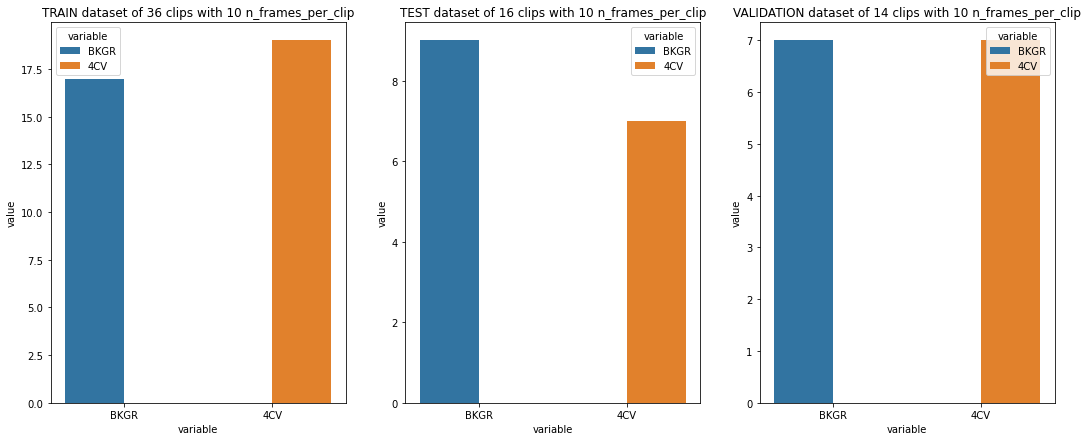

In [5]:
print(f'class_distribution(train_set): {get_class_distribution(train_set)}')
print(f'class_distribution(validation_dataset): {get_class_distribution(validation_dataset)}' )
print(f'class_distribution(test_set): {get_class_distribution(test_set)}')
    
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {Ntrain*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')
print(f'Number of frames for testing datasets {Ntest*NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP}')

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution(train_set), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(test_set), plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[2])
plt.show()



## 5. Animating frames of one clip of the dataloader

In [6]:
print(f'---------------------------------------')
clips=creating_pair_of_clips(train_dataset)
pair_clips_and_labels = pair_clips_labels(clips)


---------------------------------------
 CLIP:00 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 92 from clip_frame_clip_idx 64
 CLIP:01 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 44
 CLIP:02 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 70
 CLIP:03 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 36
 CLIP:04 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 10
 CLIP:05 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 118
 CLIP:06 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 95
 CLIP:07 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 151 from clip_frame_clip_idx 103
 CLIP:08 of BKGR label for torch.Size([1, 10, 128, 128]) TOTAL_FRAMES: 150 from clip_frame_clip_idx 31
 CLIP:09 of BKGR label for torch

<Figure size 432x288 with 0 Axes>

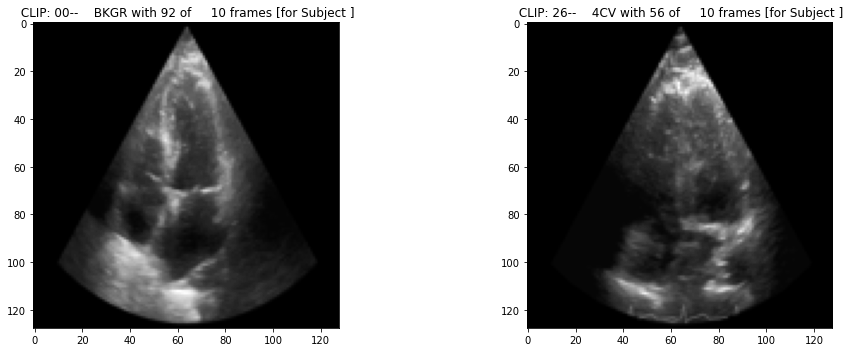

In [7]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

PAIR_OF_CLIPS = pair_clips_and_labels[0]

animated_frames=animate_clips(PAIR_OF_CLIPS)
HTML(animated_frames.to_jshtml())      

# ##SAVE ANIMATIONS
# for idx in range(0,len(pair_clips_labels)):
#     PAIR_OF_CLIPS = pair_clips_labels[idx]
#     print( f' pair_clips_labels {str(PAIR_OF_CLIPS[2])} {str(PAIR_OF_CLIPS[6])}')
    

## 6. Displayting frames in the dataloader

In [8]:

print(f'====================================================')
print(f'train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)


print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)} BATCHES of BATCH_SIZE_OF_CLIPS {BATCH_SIZE_OF_CLIPS}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} ')
        print(f'          label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'          Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'          Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()


print(f'====================================================')
print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

train_dataset.__len__() = 36
len(train_dataloader): 2 BATCHES of BATCH_SIZE_OF_CLIPS 20
    BATCH_OF_CLIPS_INDEX : 0 / 1
    sample_batched_labels.size(): torch.Size([20])
    sample_batched_labels.squeeze().size(): torch.Size([20])
    sample_batched_images.size(): torch.Size([20, 1, 10, 128, 128])
        BATCH_SIZE_IDX 0 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 10, 128, 128])
          Grid size torch.Size([10, 128, 128])
        BATCH_SIZE_IDX 1 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 10, 128, 128])
          Grid size torch.Size([10, 128, 128])
        BATCH_SIZE_IDX 2 
          label: 0
          Sample_batched_idx_image.size()  torch.Size([1, 10, 128, 128])
          Grid size torch.Size([10, 128, 128])
        BATCH_SIZE_IDX 3 
          label: 1
          Sample_batched_idx_image.size()  torch.Size([1, 10, 128, 128])
          Grid size torch.Size([10, 128, 128])
        BATCH_SIZE_IDX 4 
          lab

## 7. Define networks

In [9]:
################################
##### Define VGG3D architecture
class VGG3D(nn.Module):

    def __init__(self, input_size, n_frames_per_clip, n_classes=2):
        """
        Simple Video classifier to classify into two classes:
        Args:
            input_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
            n_classes: number of output classes
        """

        super(VGG3D, self).__init__()
        self.name = 'VGG00'
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_frames_per_clip = n_frames_per_clip
        self.n_features = np.prod(self.input_size)*self.n_frames_per_clip
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()

        
        #NOTES
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html
        #IN: [N,Cin,D,H,W]; OUT: (N,Cout,Dout,Hout,Wout)
        #[batch_size, channels, depth, height, width].
        

        self.conv0 = nn.Sequential(
                                nn.Conv3d(in_channels=1, out_channels=32,
                                    kernel_size = (3, 1, 1),  ## (-depth, -height, -width)
                                    stride =      (1, 1, 1), ##(depth/val0, height/val1, width/val2)
                                    padding =     (0, 0, 0),
                                    bias=False),
                                nn.BatchNorm3d(32),
                                nn.ReLU(True)
                                )
        
        self.conv1 = nn.Sequential(
                                nn.Conv3d(in_channels=32, out_channels=32,
                                    kernel_size = (3, 1, 1),  ## (-depth, -height, -width)
                                    stride =      (1, 1, 1), ##(depth/val0, height/val1, width/val2)
                                    padding =     (0, 0, 0),
                                    bias=False),
                                nn.BatchNorm3d(32),
                                nn.ReLU(True)
                                )
        
        
        self.conv2 = nn.Sequential(
                                nn.Conv3d(in_channels=32, out_channels=64,
                                    kernel_size = (3, 1, 1),  ## (-depth, -height, -width)
                                    stride =      (1, 1, 1), ##(depth/val0, height/val1, width/val2)
                                    padding =     (0, 0, 0),
                                    bias=False),
                                nn.BatchNorm3d(64),
                                nn.ReLU(True)
                                )
        
        self.conv3 = nn.Sequential(
                                nn.Conv3d(in_channels=64, out_channels=128,
                                    kernel_size = (3, 1, 1),  ## (-depth, -height, -width)
                                    stride =      (1, 1, 1), ##(depth/val0, height/val1, width/val2)
                                    padding =     (0, 0, 0),
                                    bias=False),
                                nn.BatchNorm3d(128),
                                nn.ReLU(True)
                                )        

        
#         self.conv4 = nn.Sequential(
#                                 nn.Conv3d(in_channels=128, out_channels=256,
#                                     kernel_size = (3, 1, 1),  ## (-depth, -height, -width)
#                                     stride =      (1, 1, 1), ##(depth/val0, height/val1, width/val2)
#                                     padding =     (0, 0, 0),
#                                     bias=False),
#                                 nn.BatchNorm3d(256),
#                                 nn.ReLU(True)
#                                 )  
        
#         self.conv0 = nn.Conv3d(in_channels=1, out_channels=64,
#                                kernel_size = (3, 3, 3),  ## (-depth, -height, -width)
#                                stride =      (3, 3, 3), ##(depth/val0, height/val1, width/val2)
#                                padding =     (0, 0, 0)
#                                )        

#         self.conv1 = nn.Conv3d(in_channels=64, out_channels=128,
#                                kernel_size = (3, 3, 3),  # (-depth, -height, -width)
#                                stride =      (3, 3, 3), ##(depth/val0, height/val1, width/val2)
#                                padding =     (0, 0, 0)
#                                )
        
#         self.conv2 = nn.Conv3d(in_channels=128, out_channels=256,
#                                kernel_size =  (1, 3, 3),  # (-depth, -height, -width)
#                                stride =       (3, 3, 3), ##(depth/val0, height/val1, width/val2)
#                                padding =      (0, 0, 0)
#                                )
        
        
#         self.conv3 = nn.Conv3d(in_channels=256, out_channels=512,
#                                kernel_size=   (2, 2, 2),  # (-depth, -height, -width)
#                                stride=        (2, 2, 2), ##(depth/val0, height/val1, width/val2)
#                                padding =      (0, 0, 0)
#                                )
        
        
#         self.pool0 = nn.MaxPool3d(
#                                 kernel_size = (1, 3, 3),  # (-depth, -height, -width)
#                                 stride =      (1, 1, 1), 
#                                 padding =     (0, 0, 0), 
#                                 dilation =    (1, 1, 1)
#                                 )


        #self.fc0 = nn.Linear(in_features=1048576, out_features=500) # 
        self.fc0 = nn.Linear(in_features=2097152, out_features=500) #128x128
        #self.fc0 = nn.Linear(in_features=4194304, out_features=500) #128x128
        self.fc2 = nn.Linear(in_features=500, out_features=self.n_classes)
        #self.fc1 = nn.Linear(in_features=2048, out_features=self.n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
        #x = x.permute(0,2,1,3,4)##[batch_size, depth,channels, height, width]
        print(f'x.shape(): {x.size()}')
        
        x = self.conv0(x)
        #print(f'x.shape(): {x.size()}') #x.shape(): x.shape(): torch.Size([2, 64, 60, 128, 128]) with kernel_size=(1, 1, 1)
        #print(f'x.shape(): {x.size()}') #x.shape():torch.Size([2, 64, 51, 29, 29]) with kernel_size=(10, 100, 100)
        print(f'conv0.size(): {x.size()}')
        
        x = self.conv1(x)
        #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
        print(f'conv1.size(): {x.size()}')
        
        x = self.conv2(x)
        #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
        print(f'conv2.size(): {x.size()}')
        
        x = self.conv3(x)
        #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
        print(f'conv3.size(): {x.size()}')
        
#         x = self.conv4(x)
#         #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
#         print(f'conv4.size(): {x.size()}')
        
        #x = self.pool0(x)
        #print(f'x.pool0..shape(): {x.size()}') 
        
        x = self.flatten(x)
        print(f'self.flatten(x) size() {x.size()}') #x.shape(): torch.Size([4, 983040])
        x = self.fc0(x)
        #print(f'x.shape(): {x.size()}') #x.shape(): torch.Size([4, 32])
        #x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        
        #print(f'x.shape(): {x.size()}') # x.shape(): torch.Size([4, 2])
        #x = self.sigmoid(x)
        
        x = self.softmax(x)
        #print(f'x.shape(): {x.size()}')  #x.shape(): torch.Size([4, 2])

        return x
        

In [10]:
################################
##### Define basicVGG architecture
class basicVGG(nn.Module):

    def __init__(self, input_size, n_frames_per_clip, n_classes=2):
        """
        Simple Video classifier to classify into two classes:
        Args:
            input_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
            n_classes: number of output classes
        """

        super(basicVGG, self).__init__()
        self.name = 'basicVGG'
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_frames_per_clip = n_frames_per_clip
        self.n_features = np.prod(self.input_size)*self.n_frames_per_clip
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.n_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=n_classes),
            #nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
        #x = x.permute(0,2,1,3,4)##[batch_size, depth,channels, height, width]
        #print(f'x.shape(): {x.size()}')

        x = self.classifier(x)

        return x
        


## 8. Sanity checks for the model and dataloaders

In [11]:
##################################################################
##################################################################
##################################################################

##################################################################
##################################################################
##################################################################
##### Tensor Shape
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

#n_frames_per_clip 
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
model.to(DEVICE) # Place model on GPU-

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(f'clip_batch.size() {clip_batch.size()}') #torch.Size([4, 60, 1, 128, 128])
##[batch_size, channels, depth, height, width]

# # frames = image.to(device)
print(model(clip_batch).shape) #torch.Size([4, 2])

# #https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
del sample_batched
torch.cuda.empty_cache()

torch.Size([20, 2])


## 8. Define Optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [12]:
#model = VGG3D(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
model = basicVGG(PRETRANSFORM_IM_SIZE, NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP) #print(config['pretransform_im_size']) #(128, 128)
model.to(DEVICE) # Place model on GPU
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



basicVGG(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=163840, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)


## 9. Training loop

In [13]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)

############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, DEVICE)
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, DEVICE)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")


#model_path = '/home/mx19/tmp/model' 
print(f' {FULL_REPO_MODEL_PATH}')
torch.save(model.state_dict(), os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)

## NOTES
    # executed time of 13m 5s for training loop with 100 epochs with LR=0.000005 of 3900 frames on Thu 24 Mar 10:02:26 GMT 2022
    # executed time of 7m 33s s for training loop with 100 epochs with LR=0.000005 of 10140 frames on Mon 28 Mar 11:48:43 BST 2022
    # executed time of 22m 45s s for training loop with 300 epochs with LR=0.000005 of 10140 frames on Mon 28 Mar 12:25:52 BST 2022
    # executed time of 28m 46s s for training loop with 300 epochs with LR=0.000005 of 10140 frames on 16:53:09 2022-03-28


----------
EPOCH 1/100
Epoch 00: | Average Train Loss: 0.700 Average Train Accuracy Loss: 45.5% 
Test Error: 
 Test Accuracy: 78.6%, Avg Test loss: 0.675257 

----------
EPOCH 2/100
Epoch 01: | Average Train Loss: 0.634 Average Train Accuracy Loss: 84.5% 
Test Error: 
 Test Accuracy: 64.3%, Avg Test loss: 0.658169 

----------
EPOCH 3/100
Epoch 02: | Average Train Loss: 0.603 Average Train Accuracy Loss: 71.5% 
Test Error: 
 Test Accuracy: 71.4%, Avg Test loss: 0.656226 

----------
EPOCH 4/100
Epoch 03: | Average Train Loss: 0.576 Average Train Accuracy Loss: 70.0% 
Test Error: 
 Test Accuracy: 78.6%, Avg Test loss: 0.629396 

----------
EPOCH 5/100
Epoch 04: | Average Train Loss: 0.549 Average Train Accuracy Loss: 76.5% 
Test Error: 
 Test Accuracy: 71.4%, Avg Test loss: 0.624926 

----------
EPOCH 6/100
Epoch 05: | Average Train Loss: 0.540 Average Train Accuracy Loss: 77.5% 
Test Error: 
 Test Accuracy: 78.6%, Avg Test loss: 0.600304 

----------
EPOCH 7/100
Epoch 06: | Average Tra

Epoch 53: | Average Train Loss: 0.260 Average Train Accuracy Loss: 90.0% 
Test Error: 
 Test Accuracy: 64.3%, Avg Test loss: 0.562962 

----------
EPOCH 55/100
Epoch 54: | Average Train Loss: 0.244 Average Train Accuracy Loss: 95.0% 
Test Error: 
 Test Accuracy: 71.4%, Avg Test loss: 0.627506 

----------
EPOCH 56/100
Epoch 55: | Average Train Loss: 0.231 Average Train Accuracy Loss: 92.0% 
Test Error: 
 Test Accuracy: 78.6%, Avg Test loss: 0.666532 

----------
EPOCH 57/100
Epoch 56: | Average Train Loss: 0.248 Average Train Accuracy Loss: 87.0% 
Test Error: 
 Test Accuracy: 71.4%, Avg Test loss: 0.566234 

----------
EPOCH 58/100
Epoch 57: | Average Train Loss: 0.201 Average Train Accuracy Loss: 97.0% 
Test Error: 
 Test Accuracy: 71.4%, Avg Test loss: 0.792954 

----------
EPOCH 59/100
Epoch 58: | Average Train Loss: 0.222 Average Train Accuracy Loss: 94.0% 
Test Error: 
 Test Accuracy: 71.4%, Avg Test loss: 0.517035 

----------
EPOCH 60/100
Epoch 59: | Average Train Loss: 0.189 Av

## 10. Visualize accuracy and loss performance

TEMP_TRAINING_CURVES_FOR____TRAINset_clips_36TESTset_clips_16VALset_clips14___EPOCHS_100_BATCH_SIZE_OF_CLIPS_20_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_10_LEARNING_RATE_0_0000050000


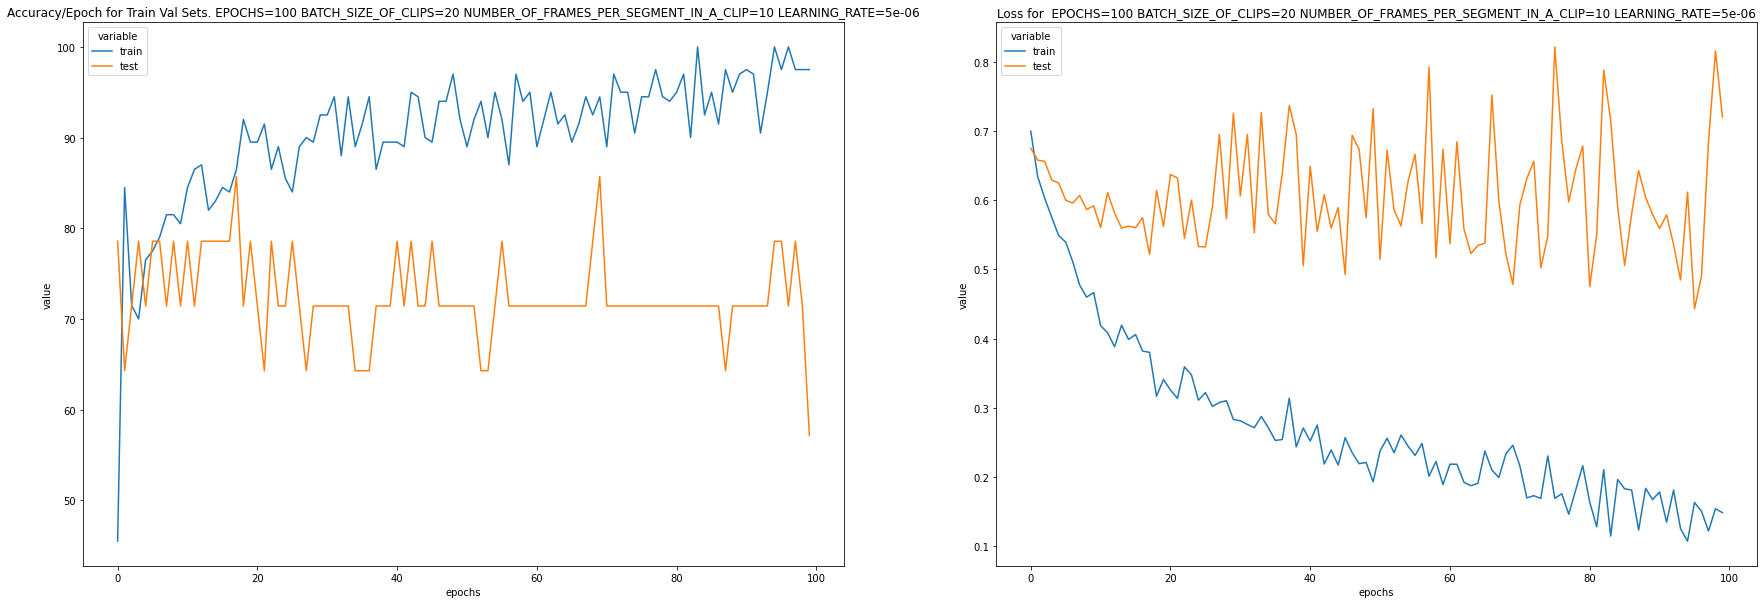

In [14]:
loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Loss for  EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Accuracy/Epoch for Train Val Sets. EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP={NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP} LEARNING_RATE={LEARNING_RATE}')
sns.set_style("ticks",{'axes.grid' : True})

WIDTH = 3
PRECISION = 10
TYPE = "f"
STR_LR = f'{LEARNING_RATE:{WIDTH}.{PRECISION}{TYPE}}'
STR_LR = STR_LR.replace(".", "_", 1)

PARAMETERS_FILENAME = "TRAINset_clips_"+str(len(train_set))+"TESTset_clips_"+str(len(test_set))+"VALset_clips"+str(len(validation_dataset))+"___EPOCHS_"+ str(f'{MAX_EPOCHS:{WIDTH}}') +"_BATCH_SIZE_OF_CLIPS_"+str(f'{BATCH_SIZE_OF_CLIPS:02}')+"_NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP_"+str(NUMBER_OF_FRAMES_PER_SEGMENT_IN_A_CLIP)+"_LEARNING_RATE_"+STR_LR

## Saving training curves at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
os.chdir(TRAINING_CURVES_PATH)
IMAGE_FILE_NAME = "TEMP_TRAINING_CURVES_FOR____"+PARAMETERS_FILENAME
print(IMAGE_FILE_NAME)
fig.savefig(IMAGE_FILE_NAME) 

## Saving training metrics in dictionaries at $HOME/repositories/echocardiography/scripts/learning-pipeline/results
LOSS_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_LOSS_"+PARAMETERS_FILENAME+'.json'
ACCU_DICTS_FILE_NAME = "TEMP_DICT_TRAINING_CURVES_FOR____"+"_ACCU_"+PARAMETERS_FILENAME+'.json'

with open(LOSS_DICTS_FILE_NAME, 'w') as file:
    file.write(json.dumps(loss_stats, indent=4))
    
with open(ACCU_DICTS_FILE_NAME, 'w') as file:
    file.write(json.dumps(accuracy_stats, indent=4))
    
    


## 11. Evaluate the model on test dataset

In [15]:
model.load_state_dict(torch.load(
    os.path.join(FULL_REPO_MODEL_PATH, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(DEVICE), sample_batched[1].to(DEVICE)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(test_set))
print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')


 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([16, 1, 10, 128, 128])
   y_train_batch.size(): torch.Size([16])
{'BKGR': 9, '4CV': 7}
y_pred_list[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1]
y_true_list[0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0]


              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.70      1.00      0.82         7

    accuracy                           0.81        16
   macro avg       0.85      0.83      0.81        16
weighted avg       0.87      0.81      0.81        16

[[6 3]
 [0 7]]


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

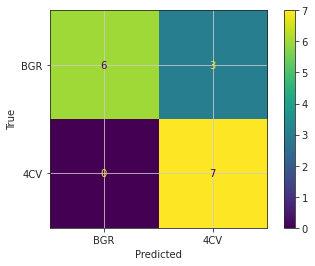

In [16]:
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

cm=confusion_matrix(y_true_list, y_pred_list)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

## 12. [**!WARNING!**] Cleanup temporal data directory 
Remove directory if a temporary was used.

```
       Make sure you know which path you will remove as you do not like to remove important files.
       shutil.rmtree
```

In [17]:
temporal_files_path = config['temporal_data_path']

shutil.rmtree(temporal_files_path)
print(f' {temporal_files_path} is empty')

 /home/mx19/datasets/vital-us/echocardiography/temporal-files/ is empty
